In [14]:
%matplotlib inline

import matplotlib
import matplotlib.offsetbox
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import StepInput, ZeroInput

from hippocampus import HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY, HippocampalCA3Node

plt.style.use("default_light")

In [32]:
# https://stackoverflow.com/a/43343934
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """size: length of bar in data units
    extent : height of bar ends in axes units"""

    def __init__(
        self,
        size=1,
        extent=0.03,
        label="",
        loc=2,
        ax=None,
        pad=0.4,
        borderpad=0.5,
        ppad=0,
        sep=2,
        txtsize=16,
        prop=None,
        frameon=True,
        linekw={},
        **kwargs
    ):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0, size], [0, 0], **linekw)
        vline1 = Line2D([0, 0], [-extent / 2.0, extent / 2.0], **linekw)
        vline2 = Line2D([size, size], [-extent / 2.0, extent / 2.0], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False, textprops={'size': txtsize})
        self.vpac = matplotlib.offsetbox.VPacker(
            children=[size_bar, txt], align="center", pad=ppad, sep=sep
        )
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(
            self,
            loc,
            pad=pad,
            borderpad=borderpad,
            child=self.vpac,
            prop=prop,
            frameon=frameon,
            **kwargs
        )

In [33]:
PULSE_START = 100  # ms
PULSE_LEN = 10  # ms
SIM_DURATION = 300  # ms


def hc_rate_with_pulse(pulse_size, pulse_mass):
    hc = HippocampalCA3Node(aswr_mass_type="variable_depression")
    for mass in hc:
        mass._noise_input = [ZeroInput()]
    hc[pulse_mass]._noise_input = [
        StepInput(
            step_size=pulse_size,
            stim_start=PULSE_START,
            stim_end=PULSE_START + PULSE_LEN,
        )
    ]
    m = MultiModel.init_node(hc)
    m.model_instance.initial_state = np.array([0.0001, 0.003, 0.012, 0.649])
    m.params["backend"] = "numba"
    m.params["duration"] = SIM_DURATION
    m.params["dt"] = 0.05
    m.run()
    return m.xr()

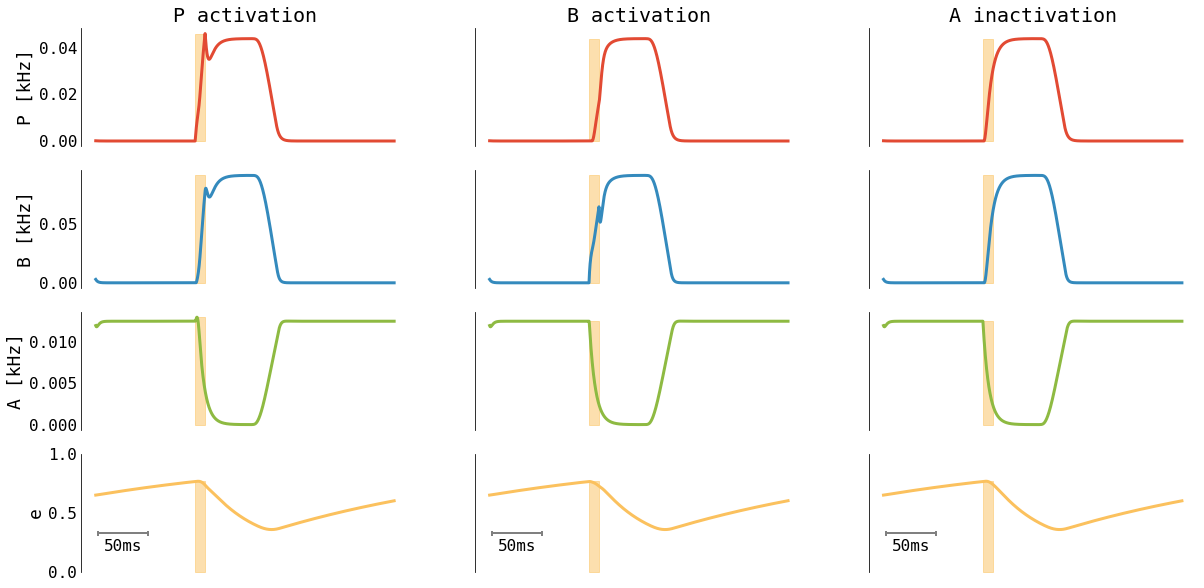

In [34]:
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey="row", figsize=(20, 10))

cols = ["C0", "C1", "C5", "C4"]
fields = ["r_mean_EXC", "r_mean_INH", "r_mean_aSWR", "e_aSWR"]
PULSE_SIZES = [60.0, 150.0, -200.0]
ylabels = ["P [kHz]", "B [kHz]", "A [kHz]", "e"]
titles = ["P activation", "B activation", "A inactivation"]

for mass in range(3):
    res = hc_rate_with_pulse(pulse_size=PULSE_SIZES[mass], pulse_mass=mass)
    for i in range(4):
        ax = axs[i, mass]
        ax.plot(
            res.time, res.sel({"output": fields[i]}).T, linewidth=3.0, color=cols[i]
        )
        ax.fill_between(
            np.arange(
                PULSE_START / 1000.0, (PULSE_START + PULSE_LEN + 0.05) / 1000.0, 0.00005
            ),
            0,
            res.sel({"output": fields[i]}).max(),
            alpha=0.5,
            color="C4",
        )
        if mass == 0:
            ax.set_ylabel(ylabels[i])
        if i == 0:
            ax.set_title(titles[mass])
        if i == 3:
            ax.set_ylim([0, 1])
            bar = AnchoredHScaleBar(
                size=0.05,
                label="50ms",
                loc=3,
                frameon=False,
                pad=0.6,
                sep=4,
                linekw=dict(color="gray", linewidth=2.0),
                ax=ax,
            )
            ax.add_artist(bar)
        ax.set_xticks([])
        sns.despine(ax=ax, bottom=True)

plt.savefig("../figs/rate_current_SWR.pdf", transparent=True, bbox_inches="tight")